In [50]:
#importing directories
import pandas as pd
import requests
import time
import numpy as np
import matplotlib.pyplot as plt

In [33]:
#importing auto industry data from screener
nse_df = pd.read_csv("Auto Industry.csv")
#tickers = nse_df['Symbol'].apply(lambda x: x + ".BSE").tolist()#converts into a python list 
#print(tickers[:5])
nse_df = nse_df.iloc[1:].reset_index(drop=True)
nse_df = nse_df.drop(columns=["S.No."], errors='ignore')
print(nse_df.head())

               Name   CMP Rs.    P/E  Mar Cap Rs.Cr.  NP Qtr Rs.Cr.  \
0  Tube Investments   2998.00  85.55        58009.46         158.19   
1     TVS Motor co.   2802.75  60.31       133155.07         697.51   
2       Tata Motors    718.20  11.17       264394.47        8556.00   
3  Samvardh. Mothe.    147.85  25.25       104031.60         984.35   
4     Maruti Suzuki  12489.00  27.09       392657.37        3911.10   

   Debt / Eq  ROE %    P/B      Ticker  
0       0.13  12.75  10.47     TIINDIA  
1       1.73  28.88  15.71    TVSMOTOR  
2       0.62  23.60   2.28  TATAMOTORS  
3       0.78  11.80   3.21   MOTHERSON  
4       0.00  15.95   4.08      MARUTI  


In [34]:
#Cleaning the data removing the strings
columns_to_clean = ['P/E', 'P/B', 'Debt / Eq', 'ROE %', 'Mar Cap Rs.Cr.']
for col in columns_to_clean:
    nse_df[col] = (
        nse_df[col]
        .astype(str)
        .str.replace(',', '', regex=False)         # Remove commas
        .str.replace('\xa0', '', regex=False)      # Remove non-breaking space
        .str.replace('\u00a0', '', regex=False)    # Remove non-breaking space (alt form)
        .str.replace(' ', '', regex=False)         # Remove ALL regular spaces
        .str.replace('−', '-', regex=False)
        .str.strip() 
    )
    nse_df[col] = pd.to_numeric(nse_df[col], errors='coerce')
print(nse_df.head(30))

                Name   CMP Rs.    P/E  Mar Cap Rs.Cr.  NP Qtr Rs.Cr.  \
0   Tube Investments   2998.00  85.55        58009.46         158.19   
1      TVS Motor co.   2802.75  60.31       133155.07         697.51   
2        Tata Motors    718.20  11.17       264394.47        8556.00   
3   Samvardh. Mothe.    147.85  25.25       104031.60         984.35   
4      Maruti Suzuki  12489.00  27.09       392657.37        3911.10   
5                M&M   3021.95  29.07       375788.22        3541.85   
6      Hero Motocorp   4297.00  19.64        85946.78        1168.75   
7        Exide Inds.    382.65  40.91        32525.25         187.91   
8      Eicher Motors   5415.00  31.40       148507.55        1362.15   
9              Bosch  31890.90  46.50        94057.87         458.20   
10      Bharat Forge   1248.10  59.20        59670.18         282.63   
11   Balkrishna Inds   2674.80  29.19        51708.49         449.48   
12        Bajaj Auto   8799.80  32.62       245741.10        219

In [43]:
#Create a value scorer

nse_df["Value Scorer"] = (nse_df["ROE %"]/100)/(nse_df["P/B"]*nse_df["Debt / Eq"]*nse_df["P/E"])
print(nse_df.tail(5))

               Name  CMP Rs.    P/E  Mar Cap Rs.Cr.  NP Qtr Rs.Cr.  Debt / Eq  \
9             Bosch  31890.9  46.50        94057.87         458.20       0.00   
10     Bharat Forge   1248.1  59.20        59670.18         282.63       0.72   
11  Balkrishna Inds   2674.8  29.19        51708.49         449.48       0.33   
12       Bajaj Auto   8799.8  32.62       245741.10        2195.65       0.17   
13    Ashok Leyland    239.7  25.26        70388.54         819.67       4.30   

    ROE %   P/B      Ticker  Value Scorer  
9   15.97  7.38    BOSCHLTD           inf  
10  12.27  6.40  BHARATFORG      0.000450  
11  17.55  5.50  BALKRISIND      0.003313  
12  26.48  7.88  BAJAJ-AUTO      0.006060  
13  28.35  6.80    ASHOKLEY      0.000384  


In [44]:
#filtering out outliers using IQR 
q1 = nse_df["Value Scorer"].quantile(0.25)
q3 = nse_df["Value Scorer"].quantile(0.75)
iqr = q3-q1

lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

nse_df_no_outliers = nse_df[(nse_df["Value Scorer"]>=lower_bound) & (nse_df["Value Scorer"]<=upper_bound)]
print(nse_df_no_outliers.head(10))

                Name  CMP Rs.    P/E  Mar Cap Rs.Cr.  NP Qtr Rs.Cr.  \
0   Tube Investments  2998.00  85.55        58009.46         158.19   
1      TVS Motor co.  2802.75  60.31       133155.07         697.51   
2        Tata Motors   718.20  11.17       264394.47        8556.00   
3   Samvardh. Mothe.   147.85  25.25       104031.60         984.35   
5                M&M  3021.95  29.07       375788.22        3541.85   
6      Hero Motocorp  4297.00  19.64        85946.78        1168.75   
7        Exide Inds.   382.65  40.91        32525.25         187.91   
8      Eicher Motors  5415.00  31.40       148507.55        1362.15   
10      Bharat Forge  1248.10  59.20        59670.18         282.63   
11   Balkrishna Inds  2674.80  29.19        51708.49         449.48   

    Debt / Eq  ROE %    P/B      Ticker  Value Scorer  
0        0.13  12.75  10.47     TIINDIA      0.001095  
1        1.73  28.88  15.71    TVSMOTOR      0.000176  
2        0.62  23.60   2.28  TATAMOTORS      0.014

In [45]:
#Filtering larger then median

median_market_cap = nse_df_no_outliers["Mar Cap Rs.Cr."].median()
filtered_df = nse_df_no_outliers[nse_df_no_outliers["Mar Cap Rs.Cr."] >= median_market_cap]
print(filtered_df.head(10))

                Name  CMP Rs.    P/E  Mar Cap Rs.Cr.  NP Qtr Rs.Cr.  \
1      TVS Motor co.  2802.75  60.31       133155.07         697.51   
2        Tata Motors   718.20  11.17       264394.47        8556.00   
3   Samvardh. Mothe.   147.85  25.25       104031.60         984.35   
5                M&M  3021.95  29.07       375788.22        3541.85   
8      Eicher Motors  5415.00  31.40       148507.55        1362.15   
12        Bajaj Auto  8799.80  32.62       245741.10        2195.65   

    Debt / Eq  ROE %    P/B      Ticker  Value Scorer  
1        1.73  28.88  15.71    TVSMOTOR      0.000176  
2        0.62  23.60   2.28  TATAMOTORS      0.014946  
3        0.78  11.80   3.21   MOTHERSON      0.001866  
5        1.62  18.05   4.91         M&M      0.000781  
8        0.02  24.07   6.98   EICHERMOT      0.054911  
12       0.17  26.48   7.88  BAJAJ-AUTO      0.006060  


In [49]:
#Getting the top three stocks 
top_value_stocks = filtered_df.sort_values(by="Value Scorer", ascending=False)

#top three stocks 
top_3 = (top_value_stocks.head(3))
print(top_3[["Name","Mar Cap Rs.Cr.","Value Scorer","Ticker"]])

             Name  Mar Cap Rs.Cr.  Value Scorer      Ticker
8   Eicher Motors       148507.55      0.054911   EICHERMOT
2     Tata Motors       264394.47      0.014946  TATAMOTORS
12     Bajaj Auto       245741.10      0.006060  BAJAJ-AUTO


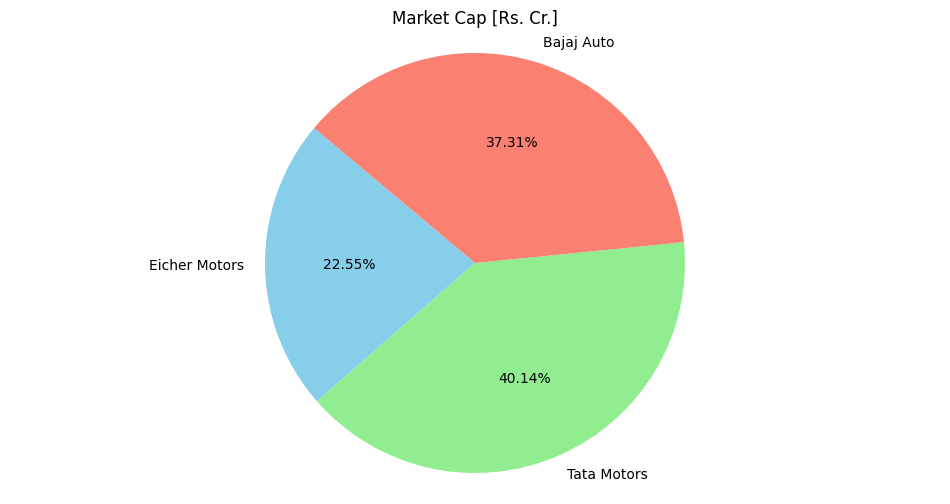

In [51]:
#plotting maket cap and value scorer of top three 
plt.figure(figsize=(12,6))
plt.pie(top_3["Mar Cap Rs.Cr."], labels = top_3["Name"],autopct='%1.2f%%', startangle=140, colors=["skyblue", "lightgreen", "salmon"])
plt.title("Market Cap [Rs. Cr.]")
plt.axis('equal')

plt.show()